In [1]:
import sys
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 401
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("J",zenith=np.array([8])*ceo.constants.ARCMIN2RAD,
                    azimuth=np.array([0])*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

In [3]:
GMT.M1.motion_CS.origin[0,2] = -1e-6
GMT.M1.motion_CS.origin[3,2] = -1e-6
GMT.M1.motion_CS.origin[1,2] = 0.5e-6
GMT.M1.motion_CS.origin[5,2] = -0.5e-6
GMT.M1.motion_CS.origin[4,2] = 0.5e-6
GMT.M1.motion_CS.origin[2,2] = -0.5e-6
GMT.M1.motion_CS.origin[6,2] = 1e-6
GMT.M1.motion_CS.update()

In [4]:
GMT.propagate(src)

In [5]:
sps = ceo.SegmentPistonSensor(GMT.M1,src)

In [6]:
src.magnitude = 15
sps.camera.reset()
sps.propagate(src)
sps.readOut(1e-2,0,16)
sps.fft()

<matplotlib.colorbar.Colorbar instance at 0x2ab8e824e998>

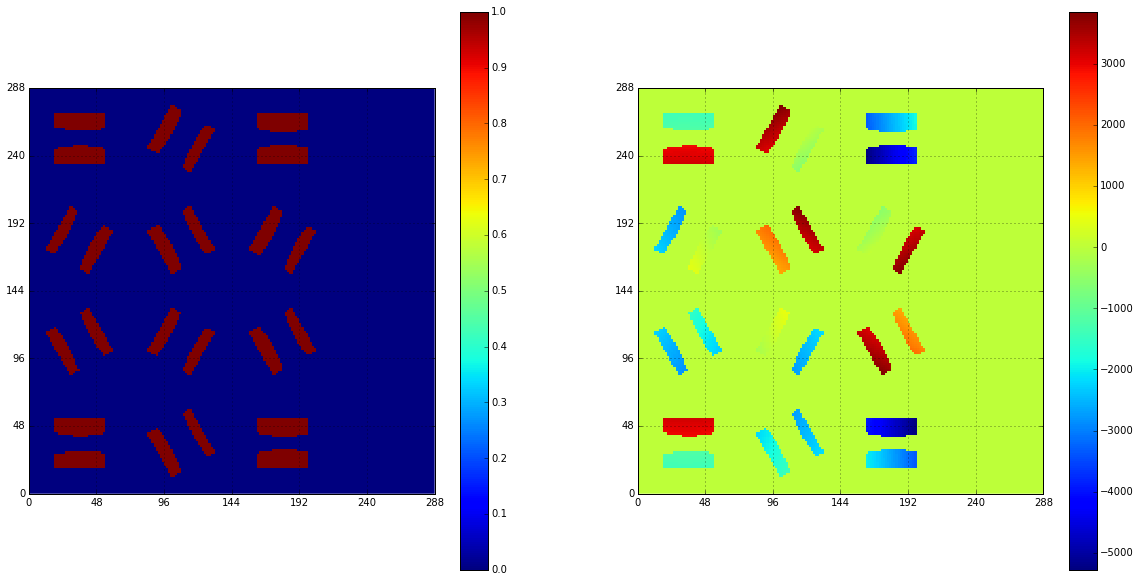

In [7]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,10))
h1 = ax1.imshow(sps.W.amplitude.host(),
               interpolation='None',extent=[0,288,0,288],
               origin='lower')
ax1.set_xticks(np.arange(0,48*7, 48))
ax1.set_yticks(np.arange(0,48*7, 48))
ax1.grid()
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.W.phase.host(units='nm'),
               interpolation='None',extent=[0,288,0,288],
               origin='lower')
ax2.set_xticks(np.arange(0,48*7, 48))
ax2.set_yticks(np.arange(0,48*7, 48))
ax2.grid()
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2ab8e84294d0>

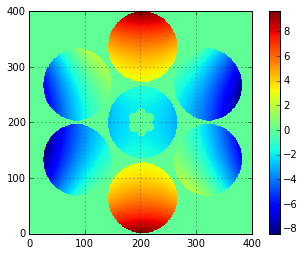

In [8]:
imshow(src.phase.host(units='micron'),interpolation='None',origin='lower')
grid()
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ab8e8679f80>

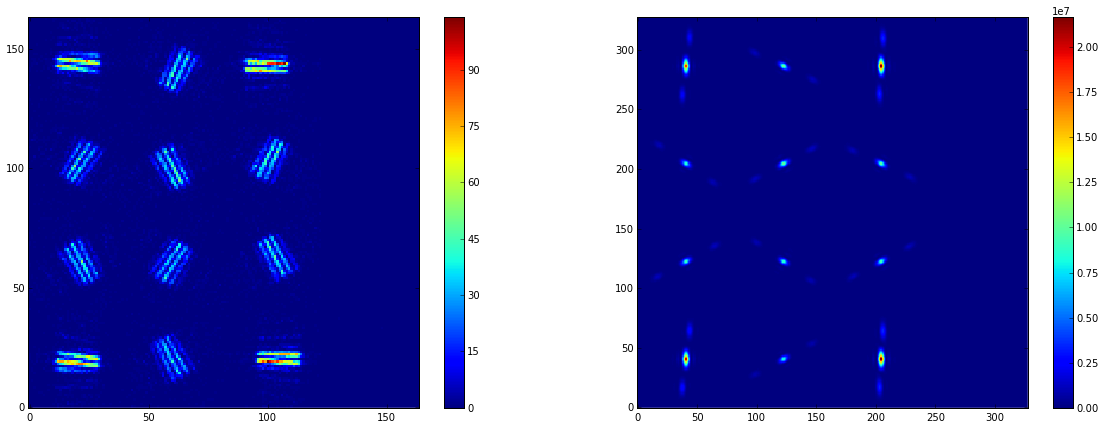

In [9]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower')
colorbar(h2,ax=ax2)

In [10]:
atm = ceo.GmtAtmosphere(0.15,30)

In [11]:
p = D/(nPx-1)
atm.get_phase_screen(src,  p, nPx, p, nPx, 0.0)

In [12]:
src.phase.shape

(402, 402)

<matplotlib.colorbar.Colorbar instance at 0x2b3300fd1488>

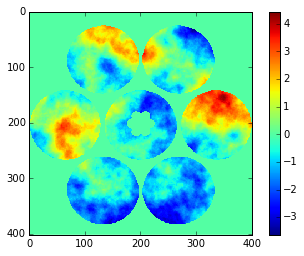

In [13]:
imshow(src.phase.host(units='micron').T,interpolation='None')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b3301f8c9e0>

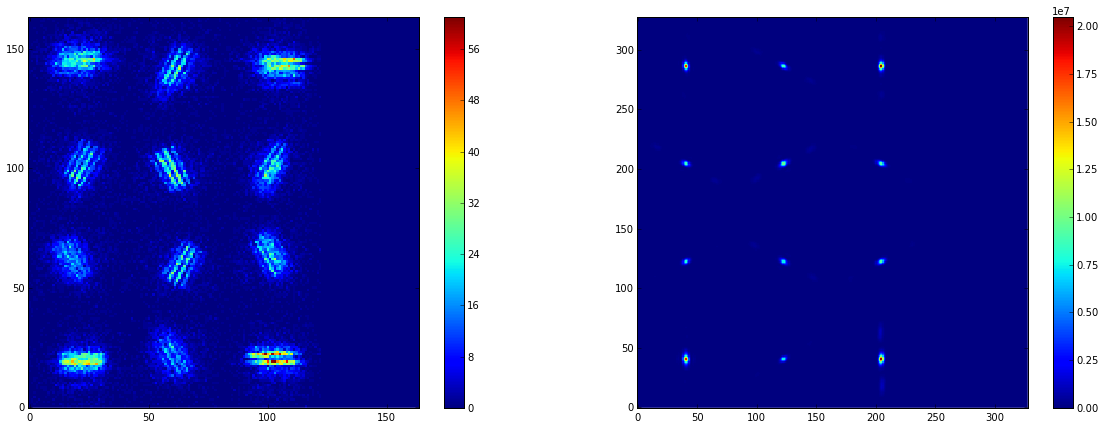

In [14]:
sps.camera.reset()
sps.propagate(src)
sps.camera.readOut(1e-2,0)
sps.fftlet.reset()
sps.fft()
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower')
colorbar(h2,ax=ax2)

In [21]:
def spsExposure(tau,exposureTime):
    T = 0
    while T<exposureTime:
        T += tau
        atm.get_phase_screen(src,  p, nPx, p, nPx, T)
        sps.propagate(src)

exposure time: 0.40s


<matplotlib.colorbar.Colorbar instance at 0x2b2221df9170>

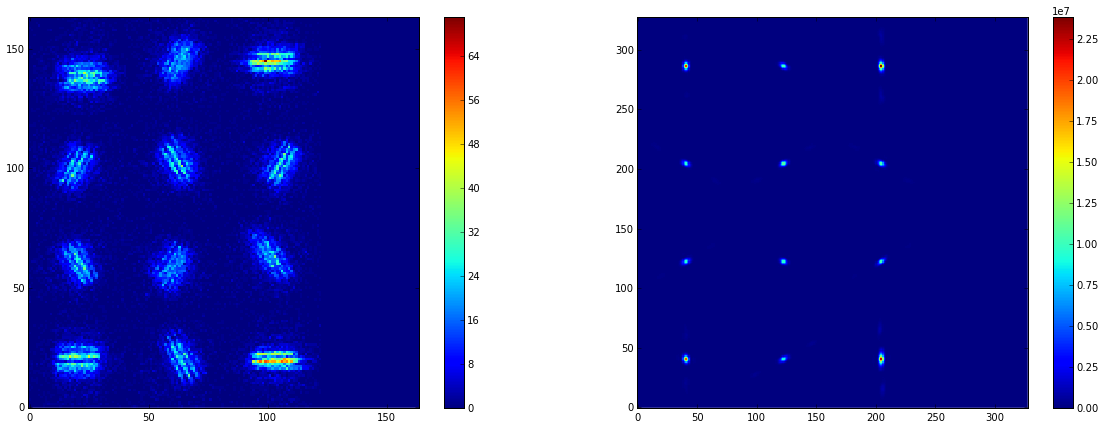

In [22]:
sps.camera.reset()
tid = ceo.StopWatch()
tid.tic()
spsExposure(1e-2,1e-2)
sps.camera.readOut(1e-2,0)
tid.toc()
print "exposure time: %.2fs" % (tid.elapsedTime*1e-3)
sps.fftlet.reset()
sps.fft()
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower')
colorbar(h2,ax=ax2)

In [56]:
def spsCoaddFFtlet(tau,exposureTime,fftExposureTime):
    T = 0.0
    while T<fftExposureTime:
        T += exposureTime
        sys.stdout.write("\r T=%.2fs" % T)
        sps.camera.reset()
        spsExposure(tau,exposureTime)
        sps.camera.readOut(tau,0)
        sps.fft()

In [59]:
sps.fftlet.reset()
tid.tic()
spsCoaddFFtlet(1e-2,1e-2,10.0)
tid.toc()
print "\nelapsed time: %.2fs" % (tid.elapsedTime*1e-3)

 T=10.01s
elapsed time: 2044.84s


<matplotlib.colorbar.Colorbar instance at 0x2b42150a77e8>

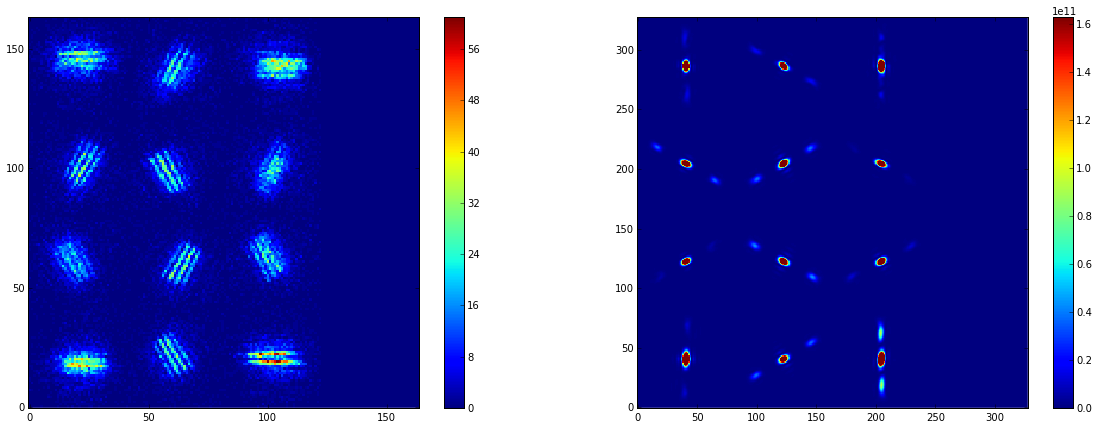

In [62]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower',vmax=sps.fftlet.host_data.max()*1e-1)
colorbar(h2,ax=ax2)